<a href="https://colab.research.google.com/github/Shirley31415926/API_heatwave/blob/main/03B%20UK%20tem%26post%20with%20lag%20and%20forecast%20effect%202023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2023 UK temperature data analysis：

We further explored the predictive power of "forecasted future temperatures" on posting behavior. The results show that the same-day temperature remains the primary driver of post volume changes (β = 5.84, p < 0.01), while forecasted temperatures for the next day and the day after did not have a statistically significant impact on posting behavior. This suggests that the public tends to react in real-time to extreme weather, rather than posting in advance based on forecast information.

In [ ]:
!pip install --upgrade atproto
!pip install pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.4/380.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.4/682.4 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1


# Post Count vs. UK Temperature / time series & OLS regression & linear relationship

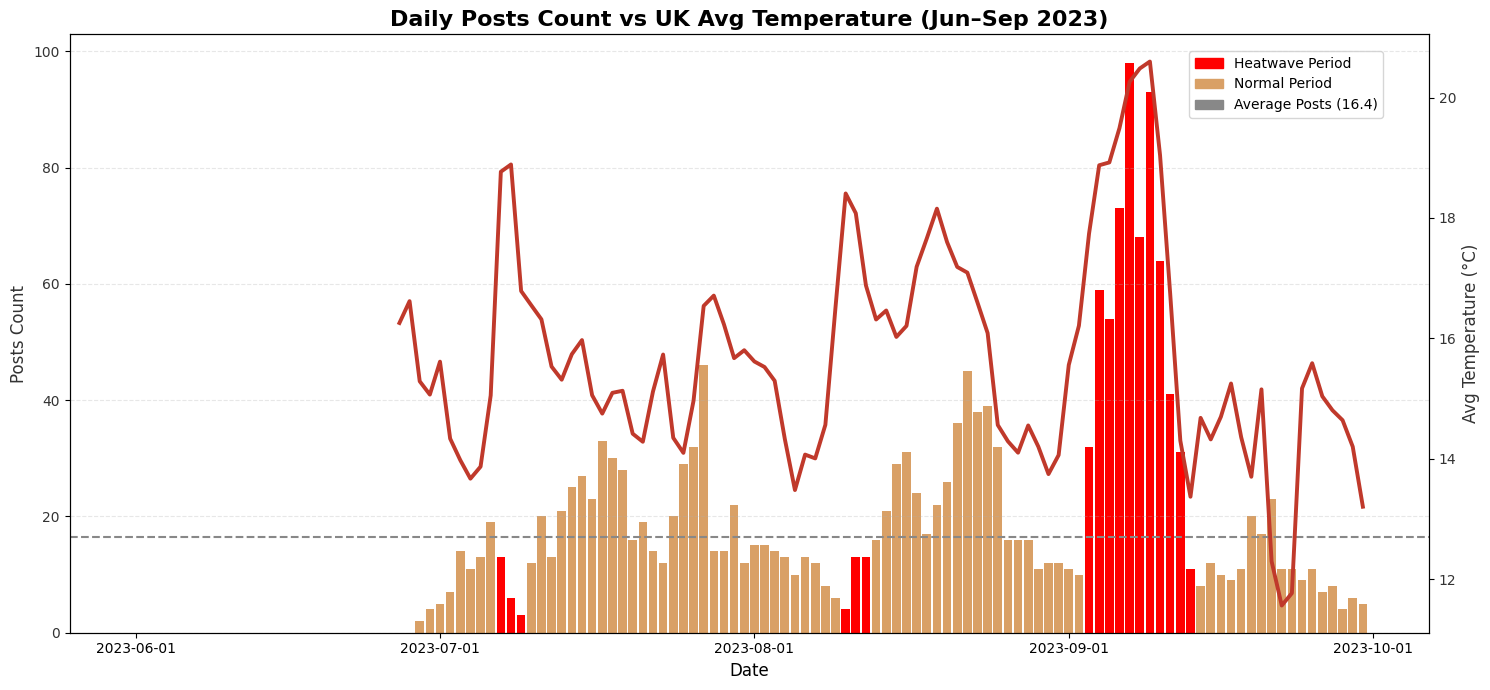

                            OLS Regression Results                            
Dep. Variable:            posts_count   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     53.15
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           9.55e-11
Time:                        19:44:15   Log-Likelihood:                -392.60
No. Observations:                  96   AIC:                             789.2
Df Residuals:                      94   BIC:                             794.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -74.0988     13.108     -5.653      0.0

In [10]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime
from collections import defaultdict
import matplotlib.patches as mpatches  # For custom legend patches

# 1. Load daily post frequency data
def load_posts_data(filepath):
    daily_counts = defaultdict(int)
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                post = json.loads(line)
                dt = datetime.strptime(post['created_at'], "%Y-%m-%dT%H:%M:%S.%f%z")
                date_str = dt.strftime("%Y-%m-%d")
                daily_counts[date_str] += 1
            except (json.JSONDecodeError, KeyError, ValueError):
                continue
    return daily_counts

# 2. Load temperature data (UK only)
def load_temperature_data(filepath, region_name):
    df_temp = pd.read_csv(filepath, parse_dates=['date'])
    df_temp.set_index('date', inplace=True)
    df_temp = df_temp.rename(columns={'avg_temp': region_name})
    df_temp = df_temp.sort_index()
    return df_temp.loc['2023-06-27':'2023-09-30']

# 3. File paths
posts_filepath = '/content/heat_posts2023.jsonl'
uk_filepath = '/content/uk_avg_temperature_2023_Jun-Oct.csv'

# Heatwave periods from the UKHSA report:
# https://www.gov.uk/government/publications/heat-mortality-monitoring-reports/heat-mortality-monitoring-report-2023

# 4. Process post data
daily_counts = load_posts_data(posts_filepath)
df_posts = pd.DataFrame.from_dict(daily_counts, orient='index', columns=['posts_count'])
df_posts.index = pd.to_datetime(df_posts.index)
full_date_range = pd.date_range(start='2023-06-01', end='2023-09-30', freq='D')
df_posts = df_posts.reindex(full_date_range, fill_value=0)
posts_avg = df_posts['posts_count'].mean()

# 5. Load UK temperature data
df_uk = load_temperature_data(uk_filepath, 'UK')

# 6. Define heatwave periods
heatwave_periods = [
    ("2023-06-08", "2023-06-14"),  # E1
    ("2023-06-23", "2023-06-26"),  # E2
    ("2023-07-07", "2023-07-09"),  # E3
    ("2023-08-10", "2023-08-12"),  # E4
    ("2023-09-03", "2023-09-13"),  # E5
]

# Generate a set of all heatwave dates
heatwave_dates = set()
for start, end in heatwave_periods:
    heatwave_dates.update(pd.date_range(start=start, end=end))

# 7. Set bar colors: red for heatwave dates, tan for normal days
bar_colors = ['#FF0000' if date in heatwave_dates else '#D9A066' for date in df_posts.index]

# 8. Plotting
fig, ax1 = plt.subplots(figsize=(15, 7))

# Bar chart: daily post counts with color highlighting
ax1.bar(df_posts.index, df_posts['posts_count'], color=bar_colors, label='Posts Count', width=0.85)
ax1.axhline(posts_avg, color='#888888', linestyle='--', linewidth=1.5, label=f'Avg Posts ({posts_avg:.1f})')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Posts Count', color='#333333', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#333333')

# Line chart: UK average temperature
ax2 = ax1.twinx()
ax2.plot(df_uk.index, df_uk['UK'], color='#C0392B', linewidth=2.8, label='UK Temp (°C)')
ax2.set_ylabel('Avg Temperature (°C)', color='#333333', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#333333')

# Title and legend
plt.title('Daily Posts Count vs UK Avg Temperature (Jun–Sep 2023)', fontsize=16, fontweight='bold')

# Custom legend patches
heat_patch = mpatches.Patch(color='#FF0000', label='Heatwave Period')
normal_patch = mpatches.Patch(color='#D9A066', label='Normal Period')
avg_line = mpatches.Patch(color='#888888', label=f'Average Posts ({posts_avg:.1f})')
fig.legend(handles=[heat_patch, normal_patch, avg_line], loc='upper right', bbox_to_anchor=(0.93, 0.93))

# Beautify x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

ax1.grid(axis='y', linestyle='--', alpha=0.3)
fig.tight_layout()
plt.show()


import statsmodels.api as sm
df_merge = pd.merge(df_posts, df_uk, left_index=True, right_index=True, how='inner')
X = df_merge[['UK']]
X = sm.add_constant(X)
y = df_merge['posts_count']
model = sm.OLS(y, X).fit()
print(model.summary())

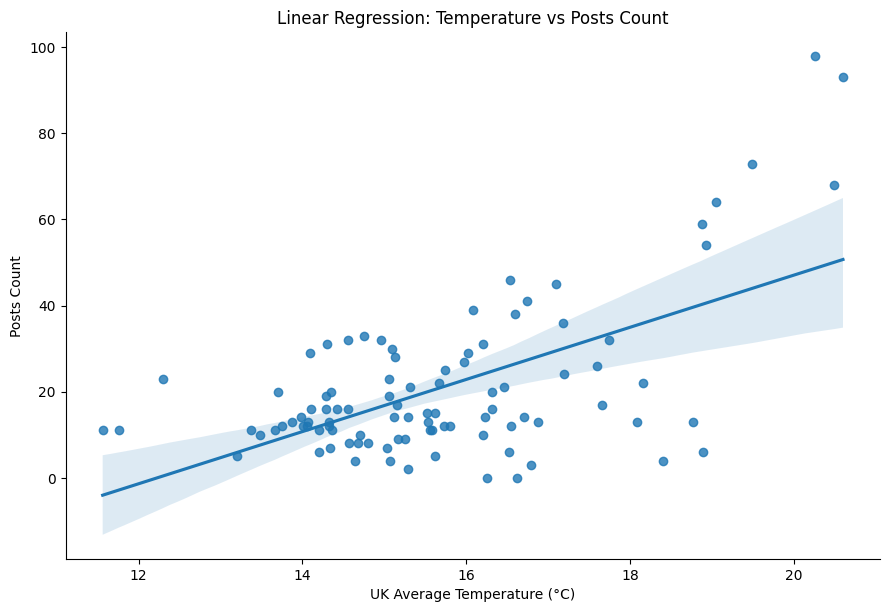

In [12]:
df_merge_renamed = df_merge.rename(columns={'UK': 'avg_temp', 'posts_count': 'post_count'})
import seaborn as sns
sns.lmplot(x='avg_temp', y='post_count', data=df_merge_renamed, height=6, aspect=1.5, ci=95)
plt.xlabel('UK Average Temperature (°C)')
plt.ylabel('Posts Count')
plt.title('Linear Regression: Temperature vs Posts Count')
plt.show()


# Lag effect vs. Posts (Lead Analysis)

In [ ]:
for lag in range(1, 4):
    merged_df[f'avg_temp_lag{lag}'] = merged_df['avg_temp'].shift(lag)

X = merged_df[['avg_temp', 'avg_temp_lag1', 'avg_temp_lag2']].dropna()
X = sm.add_constant(X)
y = merged_df.loc[X.index, 'post_count']

lag_model = sm.OLS(y, X).fit()
print(lag_model.summary())


                            OLS Regression Results                            
Dep. Variable:             post_count   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     28.15
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           7.45e-13
Time:                        19:26:48   Log-Likelihood:                -365.50
No. Observations:                  92   AIC:                             739.0
Df Residuals:                      88   BIC:                             749.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -101.7282     13.527     -7.520

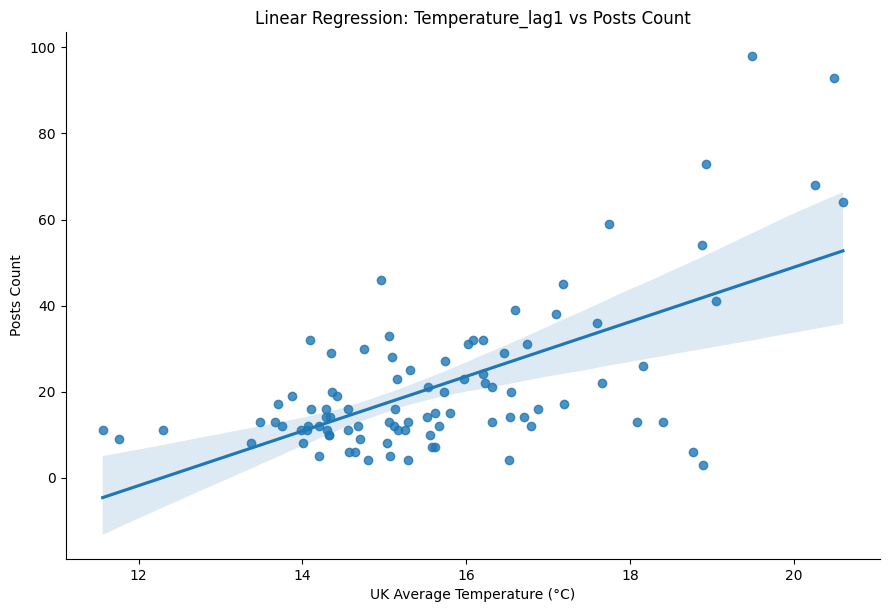

In [ ]:
import seaborn as sns

sns.lmplot(x='avg_temp_lag1', y='post_count', data=merged_df, height=6, aspect=1.5, ci=95)
plt.xlabel('UK Average Temperature (°C)')
plt.ylabel('Posts Count')
plt.title('Linear Regression: Temperature_lag1 vs Posts Count')
plt.show()


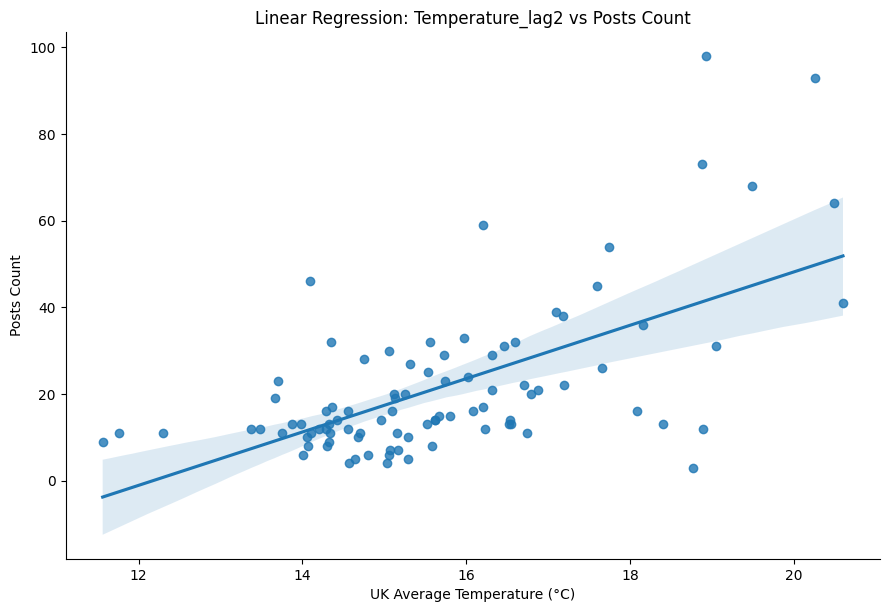

In [ ]:
import seaborn as sns

sns.lmplot(x='avg_temp_lag2', y='post_count', data=merged_df, height=6, aspect=1.5, ci=95)
plt.xlabel('UK Average Temperature (°C)')
plt.ylabel('Posts Count')
plt.title('Linear Regression: Temperature_lag2 vs Posts Count')
plt.show()

# Forecast vs. Posts


In [ ]:
import statsmodels.api as sm

# Add lead features (temperature of the next 1 and 2 days)
merged_df['avg_temp_lead1'] = merged_df['avg_temp'].shift(-1)
merged_df['avg_temp_lead2'] = merged_df['avg_temp'].shift(-2)

# Prepare data (remove rows with NaN at the end caused by shift)
df_pred = merged_df.dropna(subset=['avg_temp', 'avg_temp_lead1', 'avg_temp_lead2'])

X = df_pred[['avg_temp', 'avg_temp_lead1', 'avg_temp_lead2']]
X = sm.add_constant(X)

y = df_pred['post_count']

model_pred = sm.OLS(y, X).fit()

print(model_pred.summary())

                            OLS Regression Results                            
Dep. Variable:             post_count   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     18.15
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           2.96e-09
Time:                        19:55:58   Log-Likelihood:                -374.56
No. Observations:                  92   AIC:                             757.1
Df Residuals:                      88   BIC:                             767.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -80.6054     14.926     -5.